# Emulating the Lorenz Dynamics with an Autoregressive MLP

Given the three-dimensional state vector of the Lorenz system $u = (x, y, z) \in
\mathbb{R}^3$, we can simulate a trajectory by recursively applying a simulator
to it

$$
u^{[t+1]} = \mathcal{P}(u^{[t]}).
$$

This notebook is concerned with approximating the simulator $\mathcal{P}$ using
a neural network $f_\theta \approx \mathcal{P}$. The neural network will be a
Multilayer Perceptron (MLP).

The simulator arises as the discretization of the Lorenz equations

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma(y - x), \\
\frac{dy}{dt} &= x(\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z.
\end{aligned}
$$

using an explicit Runge-Kutta 4 scheme:

$$
\begin{aligned}
k_1 &= f(u^{[t]}), \\
k_2 &= f(u^{[t]} + \frac{\Delta t}{2} k_1), \\
k_3 &= f(u^{[t]} + \frac{\Delta t}{2} k_2), \\
k_4 &= f(u^{[t]} + \Delta t \, k_3), \\
u^{[t+1]} &= u^{[t]} + \frac{\Delta t}{6} (k_1 + 2k_2 + 2k_3 + k_4).
\end{aligned}
$$

In contrast, the parameters $\theta$ of the neural network $f_\theta$ will be
learned from trajectories by having the network predict the next state given the
current state. The next state is given according to the numerical simulator.

$$
\theta^* = \arg\min_\theta \mathbb{E}_{u^{[t]} \propto \mathcal{D}} \left[ \text{MSE}(f_\theta(u^{[t]}), \mathcal{P}(u^{[t]})) \right].
$$

Hence, the neural emulator will try to "mimic" the simulator as closely as
possible. We will evaluate its performance in terms of how well it can reproduce
the "Lorenz Map", i.e., a scatter plot of the values of two subsequent maxima of
the z-coordinate.


We will use the settings as in the original paper by Lorenz (1), i.e. $\sigma = 10$,
$\rho = 28$ and $\beta = 8/3$ together with $\Delta t = 0.01$.

---

(1) E. N. Lorenz, "Deterministic Nonperiodic Flow", Journal of the Atmospheric
Sciences, 1963,
https://journals.ametsoc.org/view/journals/atsc/20/2/1520-0469_1963_020_0130_dnf_2_0_co_2.xml

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax.tree_util as jtu
import equinox as eqx
import optax
from tqdm import tqdm

In [2]:
def lorenz_rhs(u, *, sigma, rho, beta):
    x, y, z = u
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    u_dot = jnp.array([x_dot, y_dot, z_dot])
    return u_dot

In [3]:
class LorenzStepperRK4:
    def __init__(self, dt=0.01, *, sigma=10, rho=28, beta=8/3):
        self.dt = dt
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
    
    def __call__(self, u_prev):
        lorenz_rhs_fixed = lambda u: lorenz_rhs(
            u,
            sigma=self.sigma,
            rho=self.rho,
            beta=self.beta,
        )
        k_1 = lorenz_rhs_fixed(u_prev)
        k_2 = lorenz_rhs_fixed(u_prev + 0.5 * self.dt * k_1)
        k_3 = lorenz_rhs_fixed(u_prev + 0.5 * self.dt * k_2)
        k_4 = lorenz_rhs_fixed(u_prev + self.dt * k_3)
        u_next = u_prev + self.dt * (k_1 + 2*k_2 + 2*k_3 + k_4)/6
        return u_next

In [4]:
lorenz_stepper = LorenzStepperRK4()

In [5]:
u_0 = jnp.ones(3)

In [6]:
u_0

Array([1., 1., 1.], dtype=float32)

In [7]:
lorenz_stepper(u_0)

Array([1.0125672, 1.2599177, 0.984891 ], dtype=float32)

In [8]:
# trj = [u_0,]
# u_current = u_0
# for i in range(5000):
#     u_current = jax.jit(lorenz_stepper)(u_current)
#     trj.append(u_current)
# trj = jnp.array(trj)

In [9]:
def rollout(stepper, n, *, include_init: bool = False):
    def scan_fn(u, _):
        u_next = stepper(u)
        return u_next, u_next

    def rollout_fn(u_0):
        _, trj = jax.lax.scan(scan_fn, u_0, None, length=n)

        if include_init:
            return jnp.concatenate([jnp.expand_dims(u_0, axis=0), trj], axis=0)

        return trj

    return rollout_fn

In [11]:
trj = rollout(lorenz_stepper, 5000, include_init=True)(u_0)

In [12]:
trj.shape

(5001, 3)

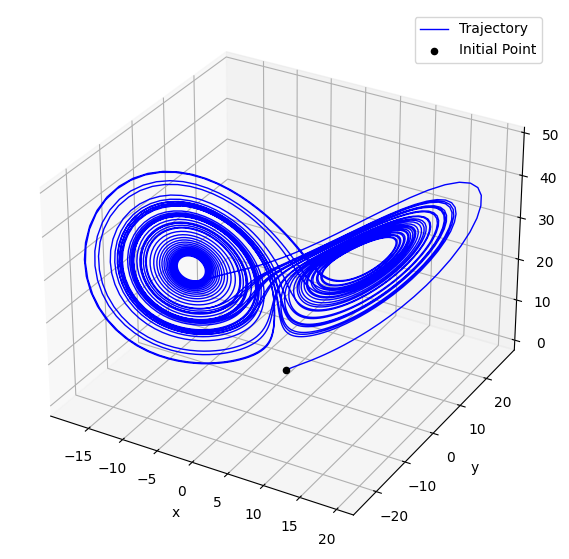

In [13]:
fig, ax = plt.subplots(
    subplot_kw={"projection": "3d"},
    figsize=(7, 7),
)

ax.plot(
    trj[:, 0],
    trj[:, 1],
    trj[:, 2],
    lw=1.0,
    color="blue",
    label="Trajectory",
)
ax.scatter3D(
    trj[0, 0],
    trj[0, 1],
    trj[0, 2],
    color="black",
    label="Initial Point",
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend()

## Lorenz Map: The Ratio of two subsequent Z peaks

<img src="https://github.com/user-attachments/assets/2aeb8b11-cd57-4220-95cc-cd482c6f4a2e" width="500">

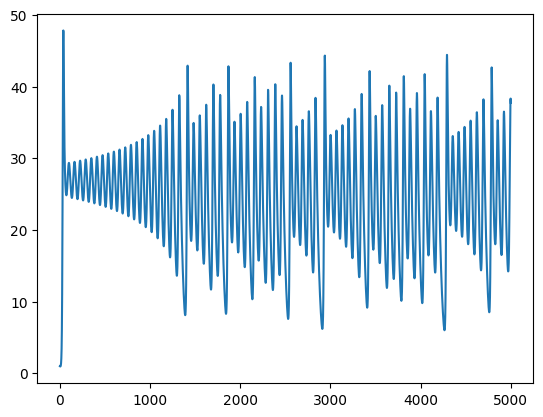

In [14]:
plt.plot(trj[:, 2])

In [15]:
def find_maxima_in_z(trj_):
    z_trj_left = trj_[:-2, 2]
    z_trj_center = trj_[1:-1, 2]
    z_trj_right = trj_[2:, 2]

    is_maximum = (z_trj_center > z_trj_left) & (z_trj_center > z_trj_right)

    maximal_values = z_trj_center[is_maximum]
    return maximal_values

In [16]:
maximal_values = find_maxima_in_z(trj)

In [17]:
maximal_values

Array([47.833958, 29.3624  , 29.507875, 29.667784, 29.838686, 30.022776,
       30.226736, 30.442154, 30.680447, 30.934145, 31.21724 , 31.528114,
       31.883173, 32.26704 , 32.709885, 33.234005, 33.83645 , 34.56554 ,
       35.504456, 36.772144, 38.801826, 42.92586 , 34.93423 , 35.988018,
       37.473053, 40.295605, 38.845295, 42.83501 , 35.105057, 36.212154,
       37.867508, 41.330654, 37.16745 , 39.5546  , 40.33332 , 38.75804 ,
       43.331177, 34.46632 , 35.3631  , 36.56552 , 38.435898, 44.328373,
       33.264313, 33.876915, 34.618126, 35.56342 , 36.86406 , 38.97903 ,
       42.173485, 35.922646, 37.415646, 40.137127, 39.16781 , 41.454346,
       36.92055 , 39.1069  , 41.739223, 36.582504, 38.47406 , 44.4338  ,
       33.103725, 33.680897, 34.38462 , 35.253475, 36.427593, 38.224495,
       42.679028, 35.314884, 36.511044, 38.332317], dtype=float32)

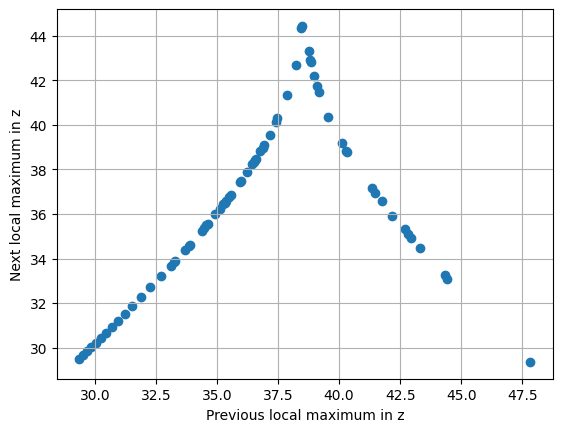

In [18]:
plt.scatter(maximal_values[:-1], maximal_values[1:])
plt.xlabel("Previous local maximum in z")
plt.ylabel("Next local maximum in z")
plt.grid()

# Parallel/Vectorized Simulation

In [19]:
u_0_set = jax.random.normal(jax.random.PRNGKey(0), (9, 3))

In [20]:
u_0_set.shape

(9, 3)

In [ ]:
# lorenz_stepper(u_0_set)

In [21]:
jax.vmap(lorenz_stepper)(u_0_set)

Array([[ 0.21339723, -0.18353522, -0.21247748],
       [-1.8342857 , -0.581421  , -0.7081617 ],
       [-0.530255  , -2.5553138 ,  0.5307995 ],
       [-0.57061917, -0.02780412,  0.33622   ],
       [-0.70517486,  0.37164515, -0.04000839],
       [ 0.709106  , -1.423997  ,  0.5493982 ],
       [ 0.25374013,  0.52599293,  1.1889024 ],
       [ 0.8763604 ,  1.8465664 ,  0.5256422 ],
       [ 0.4815886 , -0.9665574 ,  1.4818226 ]], dtype=float32)

In [22]:
trj_set_vmap_over_rollout = jax.vmap(rollout(lorenz_stepper, 5000, include_init=True))(u_0_set)
trj_set_rollout_over_vmap = rollout(jax.vmap(lorenz_stepper), 5000, include_init=True)(u_0_set)

In [23]:
trj_set_vmap_over_rollout.shape, trj_set_rollout_over_vmap.shape

((9, 5001, 3), (5001, 9, 3))

My personal preference is (BATCH, TIME, STATE)

In [24]:
trj_set = trj_set_vmap_over_rollout

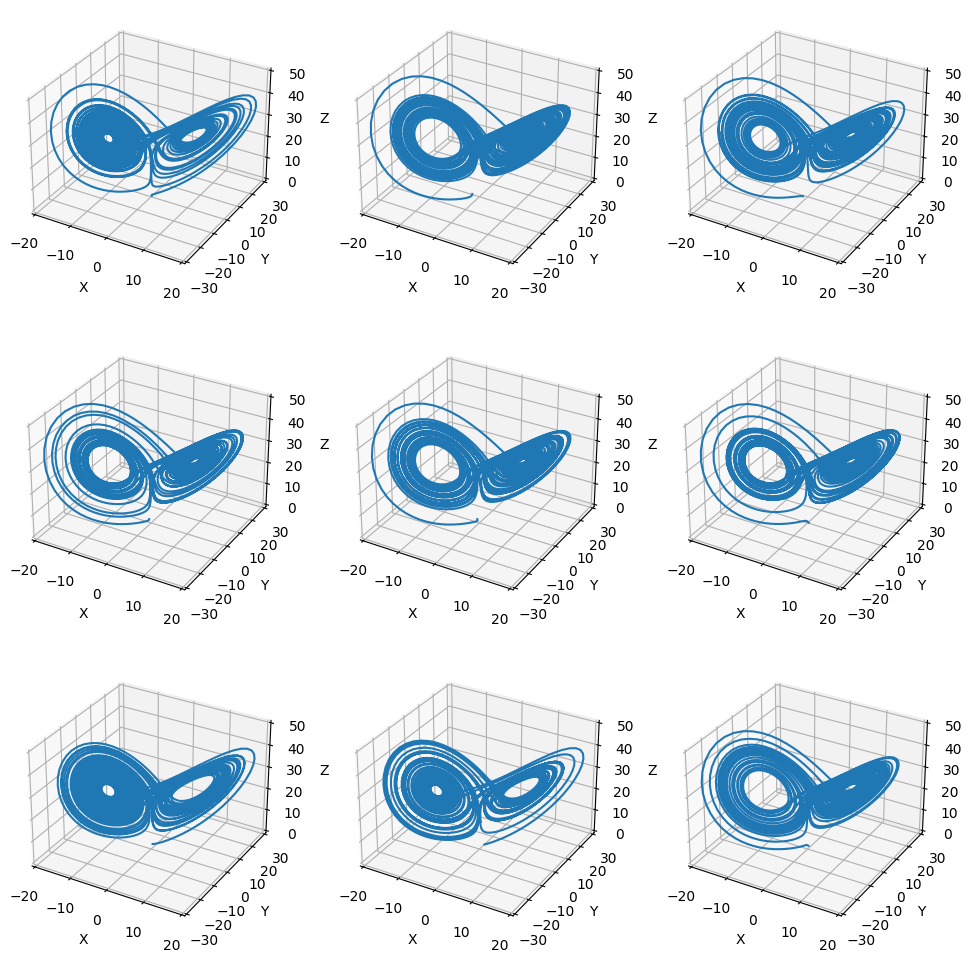

In [25]:
fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    ax.plot(
        trj_set[i, :, 0],
        trj_set[i, :, 1],
        trj_set[i, :, 2],
    )

    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

In [26]:
maximal_values_set = [find_maxima_in_z(trj) for trj in trj_set]

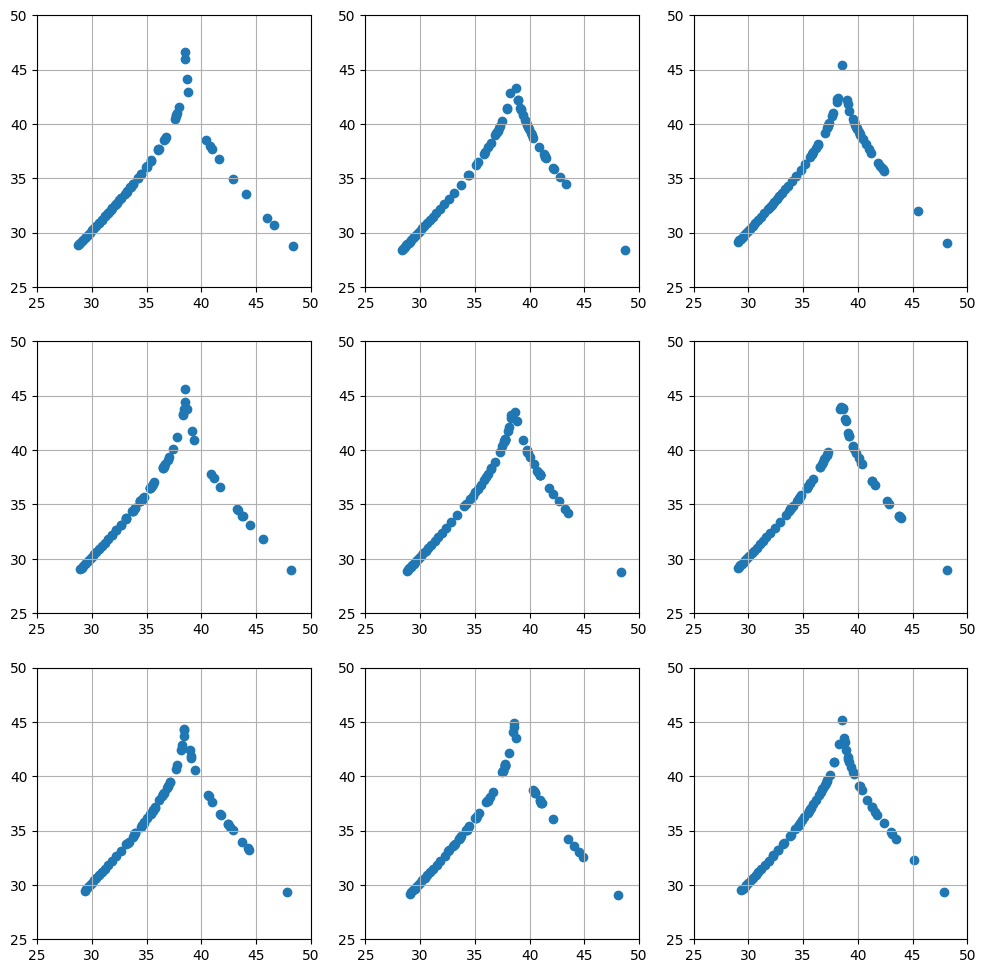

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    ax.scatter(maximal_values_set[i][:-1], maximal_values_set[i][1:])
    ax.set_xlim(25, 50)
    ax.set_ylim(25, 50)
    ax.grid()

## Autoregressive MLP Emulation

Redo data generation, but this time discard the first 2000 time steps as a "warm-up phase".

In [30]:
dataset = jax.vmap(rollout(lorenz_stepper, 5000+2000, include_init=False))(u_0_set)[:, 2000:]

In [31]:
dataset.shape

(9, 5000, 3)

In [32]:
train_dataset, test_dataset = dataset[:6], dataset[6:]

In [33]:
def slice_windows_of_two(one_trj):
    num_time_steps = one_trj.shape[0]

    windows = []
    for i in range(num_time_steps-1):
        windows.append(one_trj[i:i+2])
    
    return jnp.stack(windows)

In [36]:
train_subtrj = jnp.concatenate(jax.vmap(slice_windows_of_two)(train_dataset))

In [37]:
train_subtrj.shape

(29994, 2, 3)

In [38]:
def dataloader(
    data,
    *,
    batch_size: int,
    key,
):
    """
    Loop generator over the data. The data can be a PyTree or an Array. For
    supervised learning problems you can also hand over a tuple of Arrays
    (=PyTree).
    """

    n_samples_list = [a.shape[0] for a in jtu.tree_leaves(data)]

    if not all(n == n_samples_list[0] for n in n_samples_list):
        raise ValueError(
            "All arrays / PyTree leaves must have the same number of samples. (Leading array axis)"
        )

    n_samples = n_samples_list[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        sub_data = jtu.tree_map(lambda a: a[batch_indices], data)

        yield sub_data

In [39]:
29994 / 64

468.65625

In [40]:
469 * 200

93800

In [41]:
lorenz_emulator = eqx.nn.MLP(
    3,
    3,
    160,
    8,
    jax.nn.relu,
    key = jax.random.PRNGKey(42),
)

optimizer = optax.adam(optax.warmup_cosine_decay_schedule(0.0, 3e-4, 15_000, 100_000))
opt_state = optimizer.init(eqx.filter(lorenz_emulator, eqx.is_array))

def loss_fn(model, batch):
    x, y = batch[:, 0], batch[:, 1]
    y_pred = jax.vmap(model)(x)
    return jnp.mean(jnp.square(y_pred - y))

@eqx.filter_jit
def update_fn(model, state, batch):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, batch)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

shuffle_key = jax.random.PRNGKey(99)
train_loss_history = []

for epoch in tqdm(range(200)):
    shuffle_key, subkey = jax.random.split(shuffle_key)

    for batch in dataloader(train_subtrj, batch_size=64, key=subkey):
        lorenz_emulator, opt_state, loss = update_fn(
            lorenz_emulator,
            opt_state,
            batch,
        )
        train_loss_history.append(loss)

100%|██████████| 200/200 [10:48<00:00,  3.24s/it]


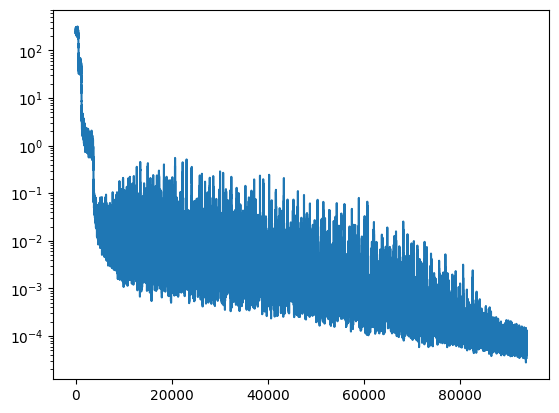

In [42]:
plt.semilogy(train_loss_history)

In [43]:
emulator_trj = jax.vmap(rollout(lorenz_emulator, 4999, include_init=True))(test_dataset[:, 0])

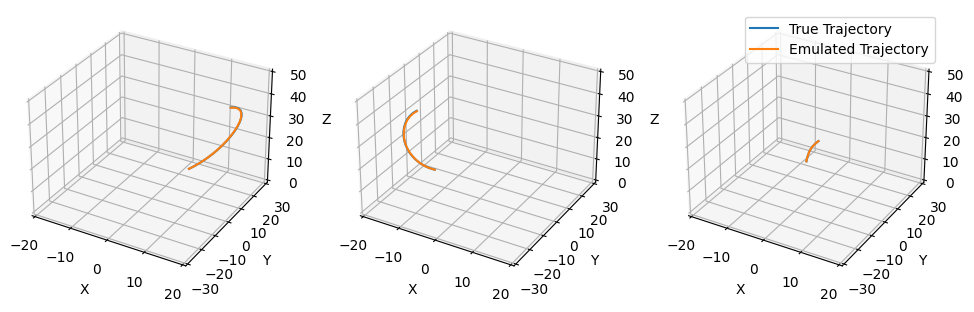

In [44]:
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(12, 5))

UP_UNTIL = 20
for i, ax in enumerate(axs.flat):
    ax.plot(
        test_dataset[i, :UP_UNTIL, 0],
        test_dataset[i, :UP_UNTIL, 1],
        test_dataset[i, :UP_UNTIL, 2],
        label="True Trajectory",
    )
    ax.plot(
        emulator_trj[i, :UP_UNTIL, 0],
        emulator_trj[i, :UP_UNTIL, 1],
        emulator_trj[i, :UP_UNTIL, 2],
        label="Emulated Trajectory",
    )

    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
plt.legend()

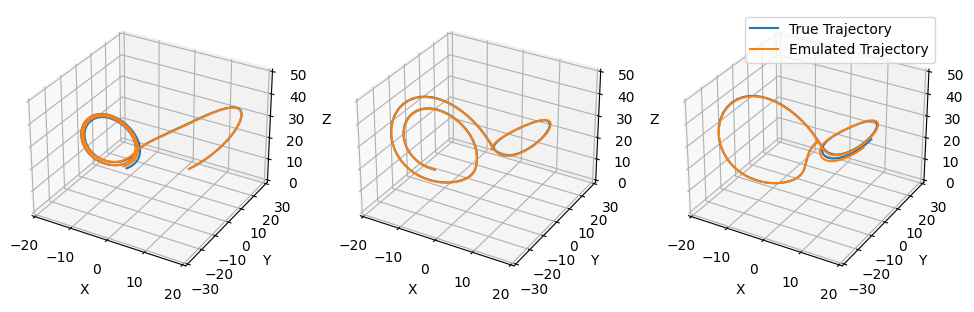

In [45]:
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(12, 5))

UP_UNTIL = 200
for i, ax in enumerate(axs.flat):
    ax.plot(
        test_dataset[i, :UP_UNTIL, 0],
        test_dataset[i, :UP_UNTIL, 1],
        test_dataset[i, :UP_UNTIL, 2],
        label="True Trajectory",
    )
    ax.plot(
        emulator_trj[i, :UP_UNTIL, 0],
        emulator_trj[i, :UP_UNTIL, 1],
        emulator_trj[i, :UP_UNTIL, 2],
        label="Emulated Trajectory",
    )

    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
plt.legend()

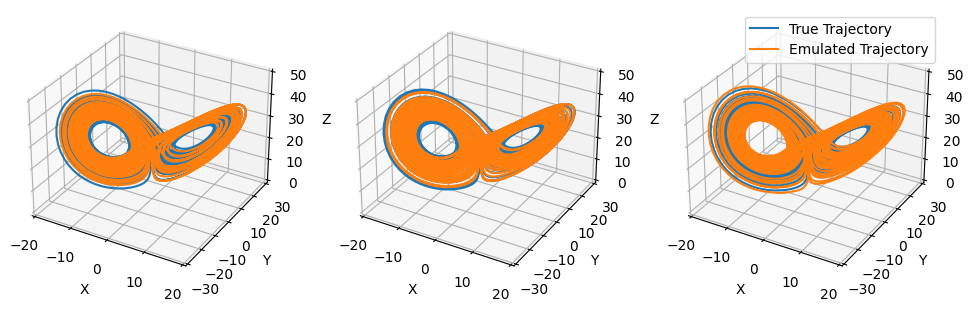

In [46]:
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(12, 5))

UP_UNTIL = -1
for i, ax in enumerate(axs.flat):
    ax.plot(
        test_dataset[i, :UP_UNTIL, 0],
        test_dataset[i, :UP_UNTIL, 1],
        test_dataset[i, :UP_UNTIL, 2],
        label="True Trajectory",
    )
    ax.plot(
        emulator_trj[i, :UP_UNTIL, 0],
        emulator_trj[i, :UP_UNTIL, 1],
        emulator_trj[i, :UP_UNTIL, 2],
        label="Emulated Trajectory",
    )

    ax.set_xlim(-20, 20)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 50)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
plt.legend()

In [47]:
maximal_values_set_true = [find_maxima_in_z(trj) for trj in test_dataset]
maximal_values_set_emulated = [find_maxima_in_z(trj) for trj in emulator_trj]

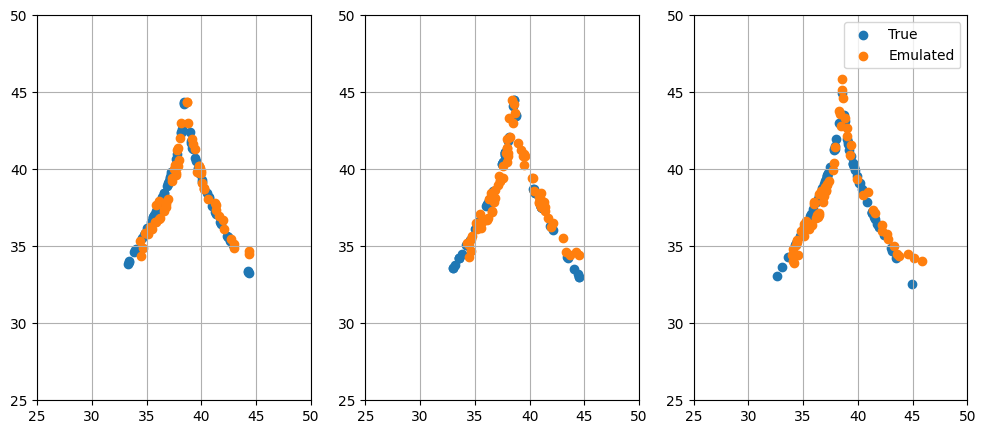

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

for i, ax in enumerate(axs.flat):
    ax.scatter(maximal_values_set_true[i][:-1], maximal_values_set_true[i][1:], label="True")
    ax.scatter(maximal_values_set_emulated[i][:-1], maximal_values_set_emulated[i][1:], label="Emulated")
    ax.set_xlim(25, 50)
    ax.set_ylim(25, 50)
    ax.grid()
plt.legend()